In [1]:
!git clone https://github.com/Arman-Rayan-Sharif/arman-text-emotion.git

fatal: destination path 'arman-text-emotion' already exists and is not an empty directory.


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("Persian Text Emotion Classification - Enhanced Version")
print("=" * 60)

Persian Text Emotion Classification - Enhanced Version


# ----------------------------
# Load and Inspect Datasets
# ----------------------------

In [3]:
train_path = "/content/arman-text-emotion/dataset/train.tsv"
test_path = "/content/arman-text-emotion/dataset/test.tsv"

train_df = pd.read_csv(train_path, sep='\t', names=['text', 'label'])
test_df = pd.read_csv(test_path, sep='\t', names=['text', 'label'])

print("Dataset Information:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Training columns: {train_df.columns.tolist()}")

Dataset Information:
Training samples: 6125
Test samples: 1151
Training columns: ['text', 'label']


# ----------------------------
# Data Quality Check
# ----------------------------

In [4]:
print("\n Data Quality Check:")

# Check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum())

print("\nMissing values in test set:")
print(test_df.isnull().sum())

# Check for duplicates
train_duplicates = train_df.duplicated().sum()
test_duplicates = test_df.duplicated().sum()
print(f"\nDuplicate rows - Train: {train_duplicates}, Test: {test_duplicates}")

# Handle missing values if any
train_df = train_df.dropna()
test_df = test_df.dropna()


 Data Quality Check:
Missing values in training set:
text     0
label    0
dtype: int64

Missing values in test set:
text     0
label    0
dtype: int64

Duplicate rows - Train: 37, Test: 0


# ----------------------------
# Exploratory Data Analysis
# ----------------------------


Label Distribution Analysis:
Training set labels:
  OTHER: 1681 (27.4%)
  ANGRY: 923 (15.1%)
  SAD: 896 (14.6%)
  FEAR: 757 (12.4%)
  SURPRISE: 739 (12.1%)
  HAPPY: 618 (10.1%)
  HATE: 511 (8.3%)

Test set labels:
  HAPPY: 275 (23.9%)
  SAD: 262 (22.8%)
  OTHER: 193 (16.8%)
  ANGRY: 154 (13.4%)
  SURPRISE: 145 (12.6%)
  HATE: 65 (5.6%)
  FEAR: 57 (5.0%)


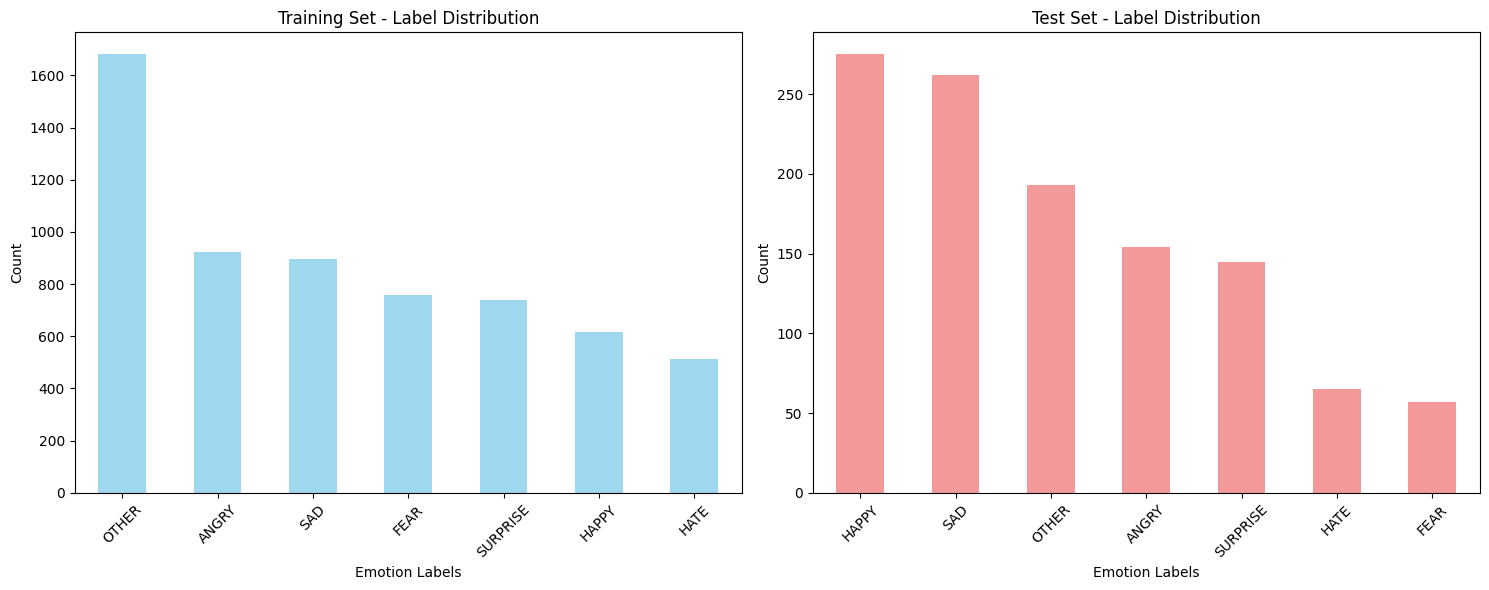

In [5]:
print("\nLabel Distribution Analysis:")

# Training set label distribution
train_label_counts = train_df['label'].value_counts()
print("Training set labels:")
for label, count in train_label_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Test set label distribution
test_label_counts = test_df['label'].value_counts()
print("\nTest set labels:")
for label, count in test_label_counts.items():
    percentage = (count / len(test_df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

train_label_counts.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_title('Training Set - Label Distribution')
ax1.set_xlabel('Emotion Labels')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

test_label_counts.plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.8)
ax2.set_title('Test Set - Label Distribution')
ax2.set_xlabel('Emotion Labels')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ----------------------------
# Text Length Analysis
# ----------------------------


Text Length Analysis:
Text length statistics (characters):
Train - Mean: 114.0, Median: 90.0
Test - Mean: 159.7, Median: 153.0

Word count statistics:
Train - Mean: 22.4, Median: 18.0
Test - Mean: 31.1, Median: 30.0


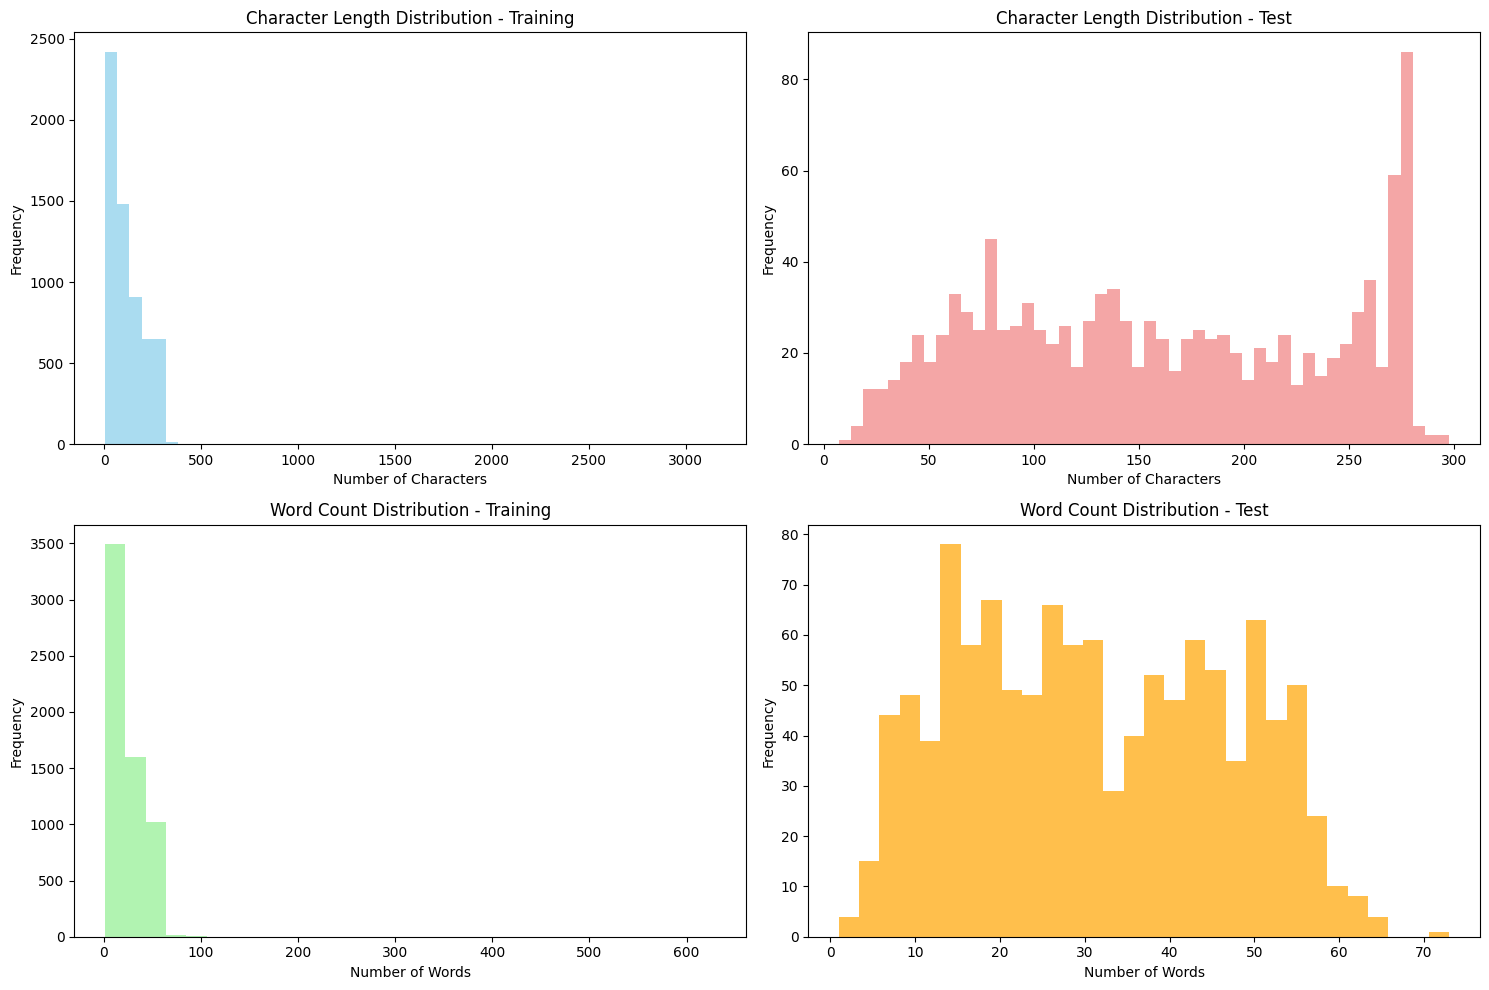

In [6]:
print("\nText Length Analysis:")

# Calculate text lengths
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

# Calculate word counts
train_df['word_count'] = train_df['text'].str.split().str.len()
test_df['word_count'] = test_df['text'].str.split().str.len()

# Statistics
print("Text length statistics (characters):")
print(f"Train - Mean: {train_df['text_length'].mean():.1f}, Median: {train_df['text_length'].median():.1f}")
print(f"Test - Mean: {test_df['text_length'].mean():.1f}, Median: {test_df['text_length'].median():.1f}")

print("\nWord count statistics:")
print(f"Train - Mean: {train_df['word_count'].mean():.1f}, Median: {train_df['word_count'].median():.1f}")
print(f"Test - Mean: {test_df['word_count'].mean():.1f}, Median: {test_df['word_count'].median():.1f}")

# Visualize text lengths
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Character length distributions
ax1.hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue', label='Train')
ax1.set_title('Character Length Distribution - Training')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Frequency')

ax2.hist(test_df['text_length'], bins=50, alpha=0.7, color='lightcoral', label='Test')
ax2.set_title('Character Length Distribution - Test')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Frequency')

# Word count distributions
ax3.hist(train_df['word_count'], bins=30, alpha=0.7, color='lightgreen', label='Train')
ax3.set_title('Word Count Distribution - Training')
ax3.set_xlabel('Number of Words')
ax3.set_ylabel('Frequency')

ax4.hist(test_df['word_count'], bins=30, alpha=0.7, color='orange', label='Test')
ax4.set_title('Word Count Distribution - Test')
ax4.set_xlabel('Number of Words')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# ----------------------------
# Enhanced Preprocessing
# ----------------------------

In [7]:
def normalize_persian(text):
    text = str(text)
    # Normalize Arabic to Persian characters
    text = text.replace('ي', 'ی').replace('ك', 'ک')
    text = text.replace('ء', 'ئ').replace('أ', 'ا').replace('إ', 'ا')
    # Remove punctuation but keep Persian characters
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Enhanced Persian stopwords list
stopwords = set([
    'از', 'با', 'برای', 'به', 'در', 'را', 'و', 'که', 'این', 'آن', 'یک', 'هر',
    'من', 'تو', 'او', 'ما', 'شما', 'آنها', 'خود', 'خودم', 'خودت', 'خودش',
    'هیچ', 'همه', 'ای', 'اگر', 'چون', 'ولی', 'اما', 'پس', 'تا', 'وقتی',
    'هم', 'هست', 'نیست', 'بود', 'بوده', 'شده', 'شد', 'می', 'نمی', 'خواهد'
])

def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords and len(word) > 1])

def preprocess(text):
    text = normalize_persian(text)
    text = remove_stopwords(text)
    return text

print("\n🔧 Preprocessing texts...")

# Store original texts for reference
train_df['original_text'] = train_df['text'].copy()
test_df['original_text'] = test_df['text'].copy()

# Preprocess texts
train_df['text'] = train_df['text'].apply(preprocess)
test_df['text'] = test_df['text'].apply(preprocess)

# Show preprocessing examples
print("\nPreprocessing Examples:")
for i in range(3):
    if i < len(train_df):
        print(f"Original: {train_df['original_text'].iloc[i][:100]}...")
        print(f"Processed: {train_df['text'].iloc[i][:100]}...")
        print(f"Label: {train_df['label'].iloc[i]}")
        print("-" * 50)


🔧 Preprocessing texts...

Preprocessing Examples:
Original: خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام پس بدم...
Processed: خیلی کوچیک هستن سایزشون بدرد نمیخوره میخوام بدم...
Label: SAD
--------------------------------------------------
Original: از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم...
Processed: صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم...
Label: HATE
--------------------------------------------------
Original:  "کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم بعد از حدود 2 ماه استفاده«متأسفانه باخبر شدیم» که فرد...
Processed: کیفیتش خیلی خوبه شک خریدم واقعا راضیم بعد حدود ماه استفادهمتاسفانه باخبر شدیم فردی ایرانشهر حداقل دخ...
Label: SAD
--------------------------------------------------


# ----------------------------
# Enhanced Vectorization
# ----------------------------

In [8]:
print("\nCreating TF-IDF features...")

# Try different vectorizer configurations
vectorizers = {
    'unigrams': TfidfVectorizer(ngram_range=(1, 1), max_features=3000, min_df=2),
    'bigrams': TfidfVectorizer(ngram_range=(1, 2), max_features=5000, min_df=2),
    'trigrams': TfidfVectorizer(ngram_range=(1, 3), max_features=7000, min_df=2)
}

results = {}

for name, vectorizer in vectorizers.items():
    print(f"\nTesting {name} configuration...")

    # Fit and transform
    X_train = vectorizer.fit_transform(train_df['text'])
    X_test = vectorizer.transform(test_df['text'])

    y_train = train_df['label']
    y_test = test_df['label']

    # Train model
    clf = LogisticRegression(max_iter=500, random_state=42)
    clf.fit(X_train, y_train)

    # Cross validation
    cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

    # Test predictions
    y_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'vectorizer': vectorizer,
        'model': clf,
        'predictions': y_pred
    }

    print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Select best configuration
best_config = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
print(f"\nBest configuration: {best_config}")
print(f"Best test accuracy: {results[best_config]['test_accuracy']:.4f}")

# Use best configuration for detailed analysis
vectorizer = results[best_config]['vectorizer']
clf = results[best_config]['model']
y_pred = results[best_config]['predictions']


Creating TF-IDF features...

Testing unigrams configuration...
CV Accuracy: 0.5587 (±0.0383)
Test Accuracy: 0.4023

Testing bigrams configuration...
CV Accuracy: 0.5576 (±0.0400)
Test Accuracy: 0.4031

Testing trigrams configuration...
CV Accuracy: 0.5553 (±0.0377)
Test Accuracy: 0.4005

Best configuration: bigrams
Best test accuracy: 0.4031


# ----------------------------
# Detailed Model Evaluation
# ----------------------------


Detailed Model Evaluation:
Classification Report:
              precision    recall  f1-score   support

       ANGRY       0.51      0.34      0.41       154
        FEAR       0.74      0.54      0.63        57
       HAPPY       0.65      0.18      0.28       275
        HATE       0.39      0.11      0.17        65
       OTHER       0.25      0.86      0.39       193
         SAD       0.63      0.50      0.55       262
    SURPRISE       0.66      0.20      0.31       145

    accuracy                           0.40      1151
   macro avg       0.55      0.39      0.39      1151
weighted avg       0.55      0.40      0.39      1151



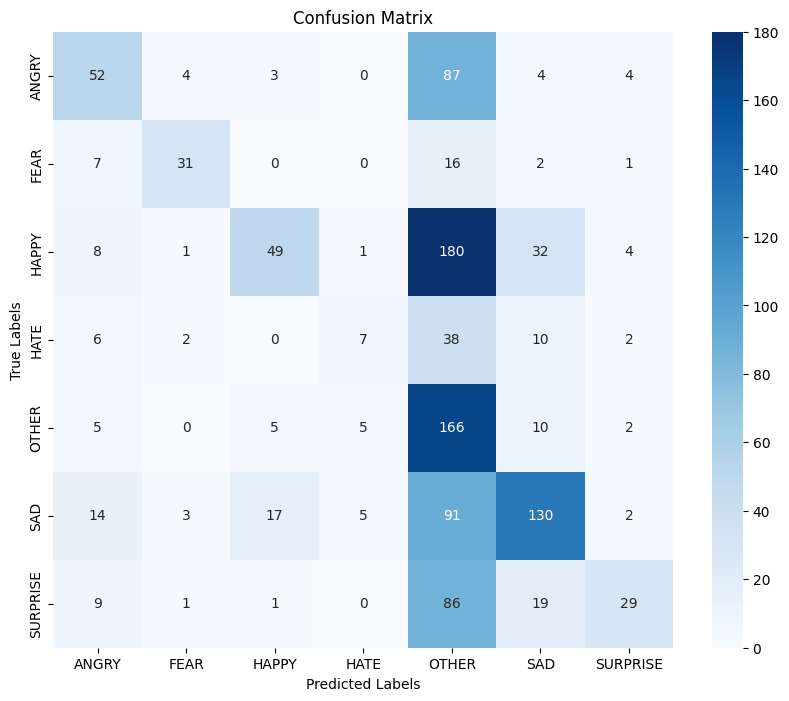


Per-class Accuracy:
  ANGRY: 0.338
  FEAR: 0.544
  HAPPY: 0.178
  HATE: 0.108
  OTHER: 0.860
  SAD: 0.496
  SURPRISE: 0.200


In [9]:
print("\nDetailed Model Evaluation:")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for label, acc in zip(labels, per_class_accuracy):
    print(f"  {label}: {acc:.3f}")

# ----------------------------
# Feature Analysis
# ----------------------------

In [10]:
print("\nMost Important Features per Class:")

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get top features for each class
n_top_features = 10
for i, class_label in enumerate(clf.classes_):
    top_features_idx = clf.coef_[i].argsort()[-n_top_features:][::-1]
    top_features = [feature_names[idx] for idx in top_features_idx]
    top_weights = [clf.coef_[i][idx] for idx in top_features_idx]

    print(f"\nTop features for '{class_label}':")
    for feature, weight in zip(top_features, top_weights):
        print(f"  {feature}: {weight:.3f}")


Most Important Features per Class:

Top features for 'ANGRY':
  اعصابم: 8.679
  خشم: 4.256
  عصبیم: 3.524
  بی: 2.653
  خورد: 2.381
  کوفت: 2.019
  عصبانی: 1.937
  عقده: 1.867
  مردم: 1.841
  خر: 1.753

Top features for 'FEAR':
  میترسم: 8.537
  ترس: 7.545
  ترسناک: 5.119
  ترسناکه: 4.760
  ترسیدم: 4.164
  وحشتناک: 3.871
  وحشتناکه: 3.749
  وحشت: 3.530
  ترسم: 3.114
  ترسناکی: 1.977

Top features for 'HAPPY':
  شاد: 3.839
  خنده: 3.303
  شادی: 3.011
  عالی: 2.984
  مرسی: 2.497
  مبارک: 2.497
  ممنونم: 2.478
  خوبی: 2.193
  لذت: 2.186
  خوب: 2.175

Top features for 'HATE':
  متنفرم: 9.646
  متنفر: 6.268
  بدم میاد: 6.123
  لعنت: 3.954
  میاد: 3.827
  بیزارم: 3.810
  بدم: 3.726
  نفرت: 2.709
  منزجر: 1.880
  میومد: 1.559

Top features for 'OTHER':
  مسئولان: 2.892
  اعتراض: 2.570
  موفقیت: 2.141
  فرار: 1.627
  انتقاد: 1.618
  خشونت: 1.478
  شگفت انگیز: 1.470
  میبینی: 1.419
  داده: 1.361
  کنید: 1.266

Top features for 'SAD':
  غم: 3.230
  بدبختی: 3.035
  ناراحت: 2.887
  متاسفانه: 2.82

# ----------------------------
# Error Analysis
# ----------------------------

In [11]:
print("\nError Analysis:")

# Find misclassified examples
test_df_copy = test_df.copy()
test_df_copy['predicted'] = y_pred
test_df_copy['correct'] = test_df_copy['label'] == test_df_copy['predicted']

misclassified = test_df_copy[~test_df_copy['correct']]

print(f"Total misclassified samples: {len(misclassified)}")
print(f"Error rate: {len(misclassified) / len(test_df_copy):.1%}")

# Show common misclassification patterns
error_patterns = misclassified.groupby(['label', 'predicted']).size().sort_values(ascending=False)
print("\nMost common misclassification patterns:")
for (true_label, pred_label), count in error_patterns.head(10).items():
    print(f"  {true_label} → {pred_label}: {count} cases")

# Show some misclassified examples
print("\nSample misclassified texts:")
for i, row in misclassified.head(5).iterrows():
    print(f"Text: {row['original_text'][:100]}...")
    print(f"True: {row['label']} | Predicted: {row['predicted']}")
    print("-" * 50)


Error Analysis:
Total misclassified samples: 687
Error rate: 59.7%

Most common misclassification patterns:
  HAPPY → OTHER: 180 cases
  SAD → OTHER: 91 cases
  ANGRY → OTHER: 87 cases
  SURPRISE → OTHER: 86 cases
  HATE → OTHER: 38 cases
  HAPPY → SAD: 32 cases
  SURPRISE → SAD: 19 cases
  SAD → HAPPY: 17 cases
  FEAR → OTHER: 16 cases
  SAD → ANGRY: 14 cases

Sample misclassified texts:
Text: اين شايد اولين عزاى عمومى واقعى است كه ياد دارم. تمام وجودم عزادار است؛ پر از گريه، پر از خشم، پر از...
True: SAD | Predicted: OTHER
--------------------------------------------------
Text: دیشب بعد از ارسال تویت مربوط به آثار باستانی تویت دیگری نوشتم ولی هرچه منتظر شدم ارسال نشد، از همون ...
True: HAPPY | Predicted: SAD
--------------------------------------------------
Text: امشب گفت نامزدی دوستش که ادم روشنفکری است بهم خورده و دختر بشدت نگران حرف مردم گفتم وای به مردم روشن...
True: SAD | Predicted: FEAR
--------------------------------------------------
Text: با آرزوی موفقیت و پیروزی #all_fo

# ----------------------------
# Model Comparison Summary
# ----------------------------


Model Configuration Comparison:
Configuration  CV_Accuracy  CV_Std  Test_Accuracy
     unigrams       0.5587  0.0383         0.4023
      bigrams       0.5576  0.0400         0.4031
     trigrams       0.5553  0.0377         0.4005


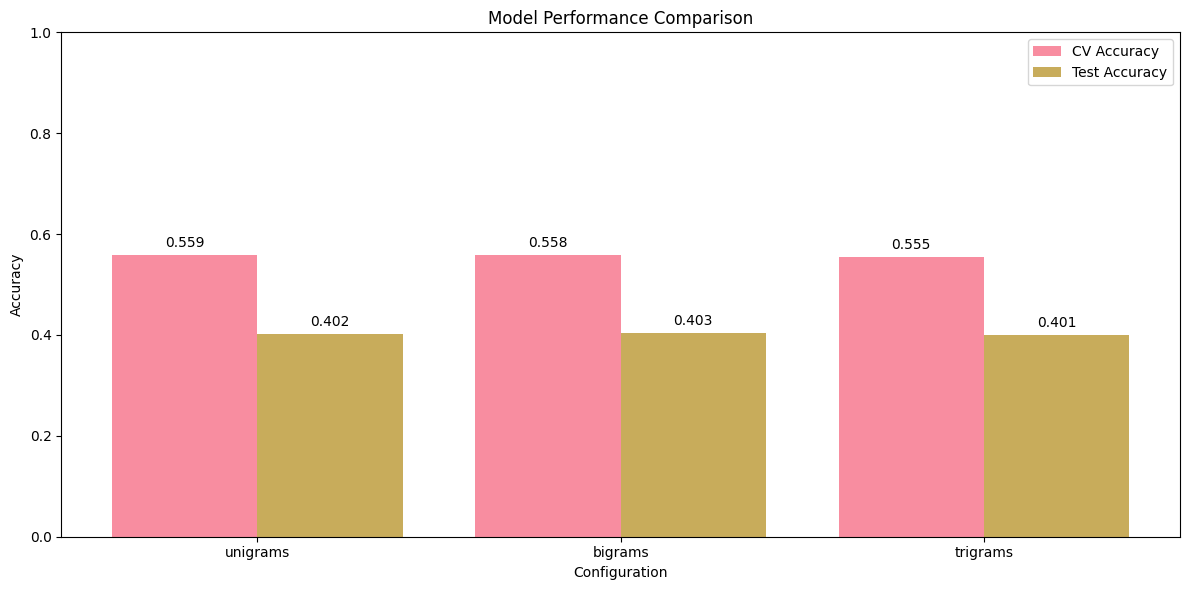

In [12]:
print("\nModel Configuration Comparison:")
comparison_df = pd.DataFrame({
    'Configuration': list(results.keys()),
    'CV_Accuracy': [results[k]['cv_mean'] for k in results.keys()],
    'CV_Std': [results[k]['cv_std'] for k in results.keys()],
    'Test_Accuracy': [results[k]['test_accuracy'] for k in results.keys()]
})

print(comparison_df.to_string(index=False, float_format='%.4f'))

# Visualize comparison
plt.figure(figsize=(12, 6))
x = range(len(comparison_df))
plt.bar([i-0.2 for i in x], comparison_df['CV_Accuracy'],
        width=0.4, label='CV Accuracy', alpha=0.8)
plt.bar([i+0.2 for i in x], comparison_df['Test_Accuracy'],
        width=0.4, label='Test Accuracy', alpha=0.8)
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, comparison_df['Configuration'])
plt.legend()
plt.ylim(0, 1)
for i, (cv, test) in enumerate(zip(comparison_df['CV_Accuracy'], comparison_df['Test_Accuracy'])):
    plt.text(i-0.2, cv+0.01, f'{cv:.3f}', ha='center', va='bottom')
    plt.text(i+0.2, test+0.01, f'{test:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# ----------------------------
# Prediction Function
# ----------------------------

In [13]:
def predict_emotion(text, vectorizer=vectorizer, model=clf):
    """
    Predict emotion for a given Persian text
    """
    processed_text = preprocess(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    probabilities = model.predict_proba(vectorized_text)[0]

    # Get probability for each class
    prob_dict = dict(zip(model.classes_, probabilities))

    return {
        'prediction': prediction,
        'confidence': max(probabilities),
        'all_probabilities': prob_dict,
        'processed_text': processed_text
    }

# Test the prediction function
print("\n🔮 Testing Prediction Function:")
sample_texts = [
    "امروز روز بسیار خوبی بود و خیلی خوشحالم",
    "من خیلی ناراحت و غمگینم",
    "روحش شاد و یادش گرامی"
]

for text in sample_texts:
    result = predict_emotion(text)
    print(f"\nText: {text}")
    print(f"Predicted emotion: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.3f}")
    print("All probabilities:")
    for emotion, prob in sorted(result['all_probabilities'].items(),
                              key=lambda x: x[1], reverse=True):
        print(f"  {emotion}: {prob:.3f}")

print("\nAnalysis Complete!")
print("Key Insights:")
print(f"- Best model configuration: {best_config}")
print(f"- Test accuracy: {results[best_config]['test_accuracy']:.1%}")
print(f"- Total features: {len(feature_names)}")
print("- Enhanced preprocessing with stopword removal")
print("- Comprehensive error analysis completed")
print("- Ready-to-use prediction function available")


🔮 Testing Prediction Function:

Text: امروز روز بسیار خوبی بود و خیلی خوشحالم
Predicted emotion: HAPPY
Confidence: 0.628
All probabilities:
  HAPPY: 0.628
  SAD: 0.157
  OTHER: 0.053
  FEAR: 0.050
  ANGRY: 0.038
  SURPRISE: 0.038
  HATE: 0.036

Text: من خیلی ناراحت و غمگینم
Predicted emotion: SAD
Confidence: 0.734
All probabilities:
  SAD: 0.734
  ANGRY: 0.062
  HAPPY: 0.061
  OTHER: 0.054
  FEAR: 0.038
  SURPRISE: 0.030
  HATE: 0.022

Text: روحش شاد و یادش گرامی
Predicted emotion: SAD
Confidence: 0.822
All probabilities:
  SAD: 0.822
  HAPPY: 0.052
  OTHER: 0.044
  ANGRY: 0.029
  SURPRISE: 0.020
  FEAR: 0.020
  HATE: 0.013

Analysis Complete!
Key Insights:
- Best model configuration: bigrams
- Test accuracy: 40.3%
- Total features: 5000
- Enhanced preprocessing with stopword removal
- Comprehensive error analysis completed
- Ready-to-use prediction function available


In [14]:
!pip install gensim

In [15]:
import re, os, json, random, numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from gensim.models import Word2Vec

# reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# داده‌ها
import pandas as pd
df_train = pd.read_csv(r"/content/arman-text-emotion/dataset/train.tsv",
                       sep='\t', header=None, names=['text','emotion'], encoding='utf-8')
df_test  = pd.read_csv(r"/content/arman-text-emotion/dataset/test.tsv",
                       sep='\t', header=None, names=['text','emotion'], encoding='utf-8')

print(df_train.head(3))
print(df_train['emotion'].value_counts())

                                                text emotion
0  خیلی کوچیک هستن و سایزشون بدرد نمیخوره میخوام ...     SAD
1     از صدای پرنده دم دمای صبح متنفرم متنفرم متنفرم    HATE
2   "کیفیتش خیلی خوبه با شک خریدم ولی واقعا راضیم...     SAD
emotion
OTHER       1681
ANGRY        923
SAD          896
FEAR         757
SURPRISE     739
HAPPY        618
HATE         511
Name: count, dtype: int64


In [17]:
import re

# حذف حرکات عربی، نیم‌فاصله و ...
DIACRITICS = re.compile(r'[\u064B-\u065F\u0670\u200c\u200f]')

def normalize_persian(text: str) -> str:
    if not isinstance(text, str): return ""
    text = text.strip()
    # نرمال‌سازی حروف
    text = (text
            .replace('ي','ی').replace('ك','ک')
            .replace('ۀ','ه').replace('ة','ه')
            .replace('ؤ','و').replace('إ','ا').replace('أ','ا').replace('آ','ا'))
    # حذف اعراب
    text = DIACRITICS.sub(' ', text)
    # حذف فاصله‌های اضافی
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# الگوی ساده برای کلمات فارسی/انگلیسی/عدد
TOKEN_PATTERN = re.compile(r"[A-Za-z\u0600-\u06FF]+|\d+")

def tokenize_fa(text: str):
    text = normalize_persian(text)
    toks = TOKEN_PATTERN.findall(text)
    toks = [t.lower() for t in toks if len(t) > 0]
    return toks

# اعمال روی داده‌ها
df_train["tokens"] = df_train["text"].apply(tokenize_fa)
df_test["tokens"]  = df_test["text"].apply(tokenize_fa)

In [18]:
# فقط جملات غیرخالی
sentences = [t for t in df_train["tokens"].tolist() if len(t) > 0]

EMB_DIM = 300
w2v = Word2Vec(
    sentences=sentences,
    vector_size=EMB_DIM, window=5, min_count=2,
    workers=4, sg=1, negative=10, epochs=15, seed=SEED
)

print("Vocab size (gensim):", len(w2v.wv))

Vocab size (gensim): 8763


In [19]:
# فقط روی train فیت می‌کنیم
train_texts = [" ".join(t) for t in df_train["tokens"]]
test_texts  = [" ".join(t) for t in df_test["tokens"]]

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Tokenizer vocab_size:", vocab_size)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test  = tokenizer.texts_to_sequences(test_texts)
# طول جملات در train و test
train_lengths = df_train["tokens"].apply(len)
test_lengths  = df_test["tokens"].apply(len)

# مثلا 95 درصد جملات زیر این طول هستند
maxlen = int(np.percentile(pd.concat([train_lengths, test_lengths]), 95))

# محدودیت معقول بذاریم (نه خیلی بزرگ، نه خیلی کوچک)
maxlen = max(8, min(maxlen, 80))

print("Chosen maxlen:", maxlen)

X_train = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test  = pad_sequences(X_test,  maxlen=maxlen, padding='post', truncating='post')

# لیبل‌ها
le = LabelEncoder()
y_train = le.fit_transform(df_train["emotion"])
y_test  = le.transform(df_test["emotion"])  # فرض: کلاس‌ها در test زیرمجموعه‌ی train هستند
num_classes = len(le.classes_)
print("Classes:", dict(zip(le.classes_, range(num_classes))))

# ماتریس امبدینگ از Word2Vec
embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, EMB_DIM)).astype(np.float32)
hits = 0
for word, idx in word_index.items():
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]
        hits += 1
print(f"Coverage from w2v: {hits}/{vocab_size} ({hits/vocab_size:.2%})")

Tokenizer vocab_size: 23059
Chosen maxlen: 55
Classes: {'ANGRY': 0, 'FEAR': 1, 'HAPPY': 2, 'HATE': 3, 'OTHER': 4, 'SAD': 5, 'SURPRISE': 6}
Coverage from w2v: 8763/23059 (38.00%)


In [20]:
from tensorflow.keras.regularizers import l2
tf.keras.backend.clear_session()

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=EMB_DIM, input_length=maxlen,
              weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4))),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max', restore_best_weights=True),
    ModelCheckpoint("best_emotion_bilstm.keras", monitor='val_accuracy', save_best_only=True, mode='max')
]

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50, batch_size=64,
    callbacks=callbacks, verbose=1
)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 305ms/step - accuracy: 0.2226 - loss: 1.9751 - val_accuracy: 0.2577 - val_loss: 1.9361
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.2949 - loss: 1.8174 - val_accuracy: 0.3524 - val_loss: 1.7627
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.3986 - loss: 1.6308 - val_accuracy: 0.5008 - val_loss: 1.4780
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.5524 - loss: 1.3216 - val_accuracy: 0.5432 - val_loss: 1.3842
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.6865 - loss: 0.9802 - val_accuracy: 0.5595 - val_loss: 1.4007
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.7749 - loss: 0.7473 - val_accuracy: 0.5726 - val_loss: 1.5340
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.8437 - loss: 0.5509 - val_accuracy: 0.5546 - val_loss: 1.7038
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.9052 - loss: 0.3949 - val_accu

Test Accuracy: 0.3814
              precision    recall  f1-score   support

       ANGRY       0.58      0.20      0.30       154
        FEAR       0.53      0.51      0.52        57
       HAPPY       0.42      0.25      0.31       275
        HATE       0.36      0.08      0.13        65
       OTHER       0.34      0.60      0.43       193
         SAD       0.35      0.64      0.45       262
    SURPRISE       0.68      0.14      0.24       145

    accuracy                           0.38      1151
   macro avg       0.46      0.35      0.34      1151
weighted avg       0.44      0.38      0.35      1151



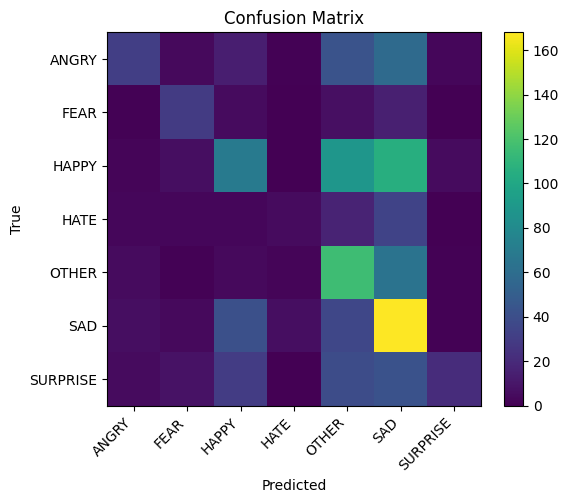

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

y_prob = model.predict(X_test, verbose=0)
y_pred = y_prob.argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

# ماتریس درهم‌ریختگی
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
plt.tight_layout()
plt.show()

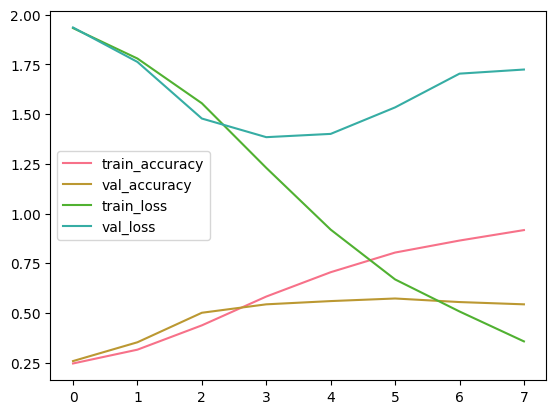

In [22]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [23]:
def prepare_texts(texts):
    toks = [" ".join(tokenize_fa(t)) for t in texts]
    seqs = tokenizer.texts_to_sequences(toks)
    return pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')

def predict_emotion(text):
    x = prepare_texts([text])
    prob = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(prob))
    return {"emotion": le.inverse_transform([idx])[0],
            "probs": {cls: float(prob[i]) for i, cls in enumerate(le.classes_)}}

# نمونه
print(predict_emotion("خیلی خوشحالم امروز نتیجه‌اش عالی شد!"))
print(predict_emotion("حالم بده و از همه چی خسته‌ام"))


{'emotion': 'HAPPY', 'probs': {'ANGRY': 0.003196040168404579, 'FEAR': 0.0342351570725441, 'HAPPY': 0.6833015084266663, 'HATE': 0.00041358271846547723, 'OTHER': 0.13517405092716217, 'SAD': 0.04628494009375572, 'SURPRISE': 0.09739472717046738}}
{'emotion': 'OTHER', 'probs': {'ANGRY': 0.03779275342822075, 'FEAR': 0.027425481006503105, 'HAPPY': 0.15174709260463715, 'HATE': 0.05259447544813156, 'OTHER': 0.6259905099868774, 'SAD': 0.058802999556064606, 'SURPRISE': 0.04564671963453293}}


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

train_texts_joined = [" ".join(t) for t in df_train["tokens"]]
test_texts_joined  = [" ".join(t) for t in df_test["tokens"]]

# TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_texts_joined)
X_test_tfidf  = tfidf.transform(test_texts_joined)

# FastText embeddings
EMB_DIM = 100
from gensim.models import FastText
sentences = df_train['tokens'].tolist() + df_test['tokens'].tolist()
ft_model = FastText(sentences, vector_size=EMB_DIM, window=5, min_count=1, sg=1, epochs=20, seed=SEED)

def sentence_vector(tokens):
    vecs = [ft_model.wv[t] for t in tokens if t in ft_model.wv]
    if len(vecs) == 0:
        return np.zeros(EMB_DIM)
    return np.mean(vecs, axis=0)

X_train_emb = np.array([sentence_vector(t) for t in df_train['tokens']])
X_test_emb  = np.array([sentence_vector(t) for t in df_test['tokens']])

# ترکیب TF-IDF و embedding
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, X_train_emb])
X_test_combined  = hstack([X_test_tfidf, X_test_emb])


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

estimators = [
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED)),
    ('svc', LinearSVC(class_weight='balanced', max_iter=2000, random_state=SEED)),
    ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=SEED))
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED),
    cv=5
)


              precision    recall  f1-score   support

       ANGRY       0.52      0.56      0.54       154
        FEAR       0.62      0.68      0.65        57
       HAPPY       0.59      0.41      0.48       275
        HATE       0.32      0.26      0.29        65
       OTHER       0.38      0.61      0.47       193
         SAD       0.52      0.61      0.56       262
    SURPRISE       0.60      0.29      0.39       145

    accuracy                           0.50      1151
   macro avg       0.51      0.49      0.48      1151
weighted avg       0.52      0.50      0.49      1151



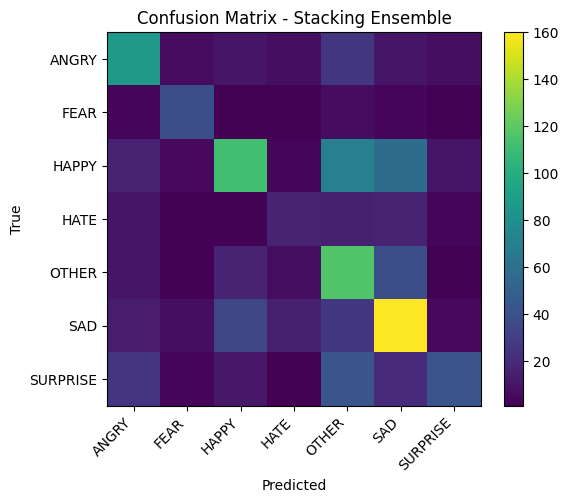

In [27]:
stack_model.fit(X_train_combined, y_train)
y_pred = stack_model.predict(X_test_combined)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ماتریس درهم‌ریختگی
cm = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix - Stacking Ensemble')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le.classes_)
plt.tight_layout()
plt.show()
